In [1]:
#load data, condensed as we did this previously
def load_clinical_eeg_data(datapath, sub):
    import pandas as pd
    alldata = pd.read_csv(os.path.join(datapath, sub + '.csv')) #removed 'train' bc of how I saved
    alldata.rename(columns={'Unnamed: 0': 'Index'})
    eegevents = alldata[['labels', 'chunks']]
    alldata.drop(['Unnamed: 0', 'labels', 'chunks'], axis=1, inplace=True)
    names = alldata.keys()
    return alldata.iloc[:].as_matrix(), eegevents, names
import os
import numpy as np
os.chdir("C:\\Users\\adam1brownell\\Desktop\Winter2017\\188B Files\Project")
path = os.getcwd()

#Get subject names from appropriate dir, -4 for .csv suffux
subjects = [f[:-4] for f in os.listdir(path)]

data, label_chunk, nodes = load_clinical_eeg_data(path,subjects[3])

(323712L,)


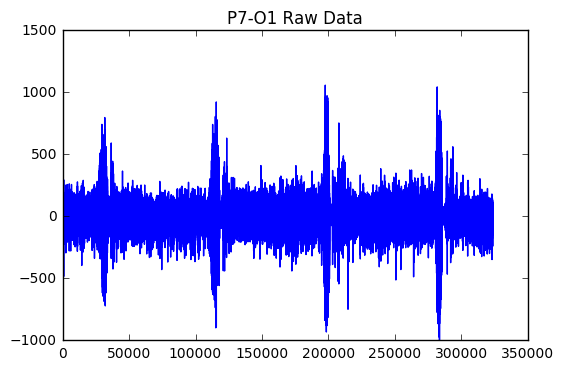

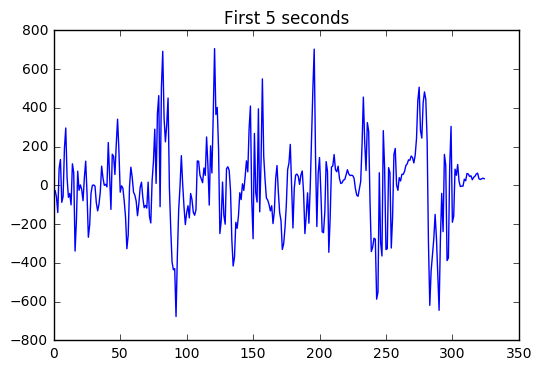

In [2]:
#Visualize Raw Data
import matplotlib.pyplot as plt

#Random Node choice
x = data[:,3]
print x.shape
time = [i for i in range(len(x))]
plt.plot(time,x)
plt.title(nodes[3] + " Raw Data")
plt.show()
#plt.plot(time[1:325], x[1:325], label = "10min Before")
seiz = 200000
plt.plot(time[1:325], x[seiz-324:seiz], label = "Seizure")
plt.title("First 5 seconds")
plt.show()

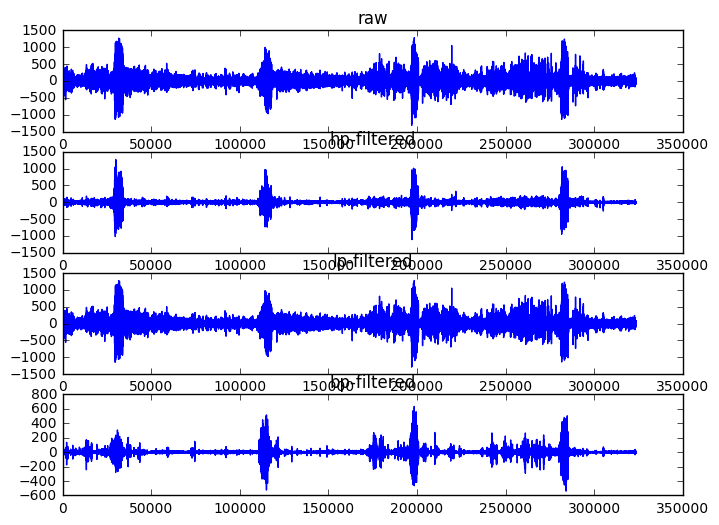

In [3]:
#Jeff Code

def apply_filters(x, order=4, fs=512.0, filt=None, btype='low', axis=0):
    from scipy.signal import butter, filtfilt
    nyq = .5 * fs
    
    if filt is None:
        return x
    if isinstance(filt, list):
        f = [i/nyq for i in filt]
        btype='band'
    else:
        f = filt/nyq
        
    b, a = butter(order, f, btype=btype, analog=False)
    x = filtfilt(b, a, x, axis=axis)
    return x

def plot_filter(order=4, fs=512.0, filt=None, btype='low'):
    from scipy.signal import decimate, butter, freqs
    nyq = .5 * fs
    if filt is None:
        return None
    if isinstance(filt, list) and len(filt) > 1:
        f = [i/nyq for i in filt]
        btype='band'
    else:
        f = filt/nyq
    b, a = butter(order, f, btype=btype, analog=True)
    w, h = freqs(b, a)
    plt.plot(w, 20 * np.log10(abs(h)))
    plt.xscale('log')
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()

f, axarr = plt.subplots(4, 1, figsize=(8, 6))
axarr[0].plot(data[:,0])
axarr[0].set_title('raw')


x_filt = apply_filters(data[:,0], order=4, fs=64, filt=5, btype='high')
axarr[1].plot(x_filt)
axarr[1].set_title('hp-filtered')


x_filt = apply_filters(data[:,0], order=4, fs=64, filt=25, btype='low')
axarr[2].plot(x_filt)
axarr[2].set_title('lp-filtered')

x_filt = apply_filters(data[:,3], order=4, fs=64, filt=[12, 30], btype='band')
axarr[3].plot(x_filt)
axarr[3].set_title('bp-filtered')
plt.show()

In [4]:
def one_sec_chunks(data):
    i = 0
    j = 0
    sec_array = [[] for i in range(len(data)/64)]
    while i <= len(data):
        sec_array[j] = np.array(data[i:i+64])
        i = i +64
        j = j + 1
                 
    return np.array(sec_array)

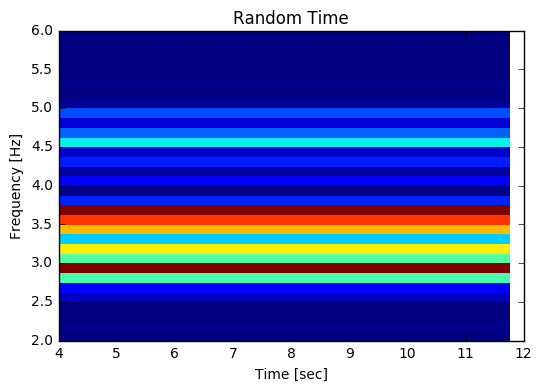

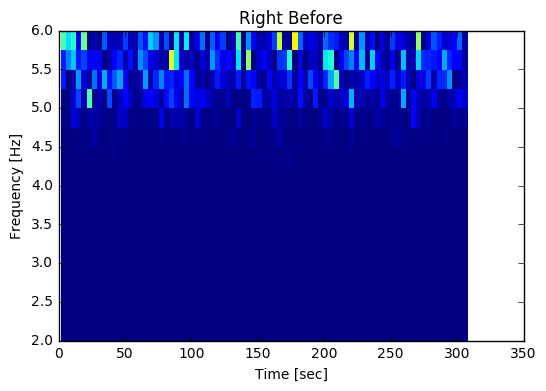

ValueError: operands could not be broadcast together with shapes (129,2) (129,80) 

In [54]:
from scipy import signal
import numpy as np
#build a 1 second time signature
#Pass band filter on each node
data2 = apply_filters(data[:,2],order =4, fs=64, filt=[5, 10], btype='band')
#sec_array = one_sec_chunks(data2)
i = 20000

f,t, Sxx = signal.spectrogram(data2[100:740], fs=32, axis = 0, noverlap = 8)
plt.pcolormesh(t, f, Sxx)
plt.ylim([2,6])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Random Time')
plt.show()

labels = np.array(label_chunk)[:,0]
i = 0
while labels[i] != 1:
    i = i+1
f,t, Sxx2 = signal.spectrogram(data2[:20000], fs=64, axis = 0, noverlap = 8)
plt.pcolormesh(t, f, Sxx2)
plt.ylim([2,6])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Right Before')
plt.show()

j = i
while labels[j] != 0:
    j = j+1
f,t, Sxx = signal.spectrogram(data2[j-640:j], fs=64, axis = 0, noverlap = 8)
plt.pcolormesh(t, f, Sxx + Sxx2)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Seizure')
plt.show()

In [6]:
def re_label2(chunks,labels):
    pLabel = [0 for i in range(len(labels))]
    seiz_rn = False
    for datapoint in range(len(labels)):
        #If no seizure rn and none before, add 0
        if labels[datapoint] == 0 and seiz_rn == False:
            pLabel[datapoint] = 0 #I don't need this since it already is set to 0 but kept for readibility

        #If seizure rn and yes before, add 1
        elif labels[datapoint] == 1 and seiz_rn == True:
                pLabel[datapoint] = 1

        #If seizure rn and none before, add 1 AND change the last 640 (10sec) of pLabel to 2
        elif labels[datapoint] == 1 and seiz_rn == False:
            for j in range(datapoint-640,datapoint+1):
                pLabel[j] = 2
            seiz_rn = True

        #If label is 0 and seiz is true, seiz just ended
        else:
            pLabel[datapoint] = 0 #Don't need, just for reading
            seiz = False
    
    return pLabel        
    
def bp_specgrammer(data, label):
    i = 640
    specs = []
    spec_label = []
    band_data =  apply_filters(data,order =4, fs=64, filt=[5, 10], btype='band')
    while i < len(data[:,1]):
        #Build 10 sec spectrograms, flatten and append
        
        #Get Spectrogram for all nodes and add them together
        big_Sxx = 0
        for node in range(len(data[1,:])):
            f,t, Sxx = signal.spectrogram(band_data[i-640:i], fs=64, axis = 0, noverlap = 8)
            big_Sxx = big_Sxx + Sxx
         
        #Flatten + Append super spectrogram
        specs.append(np.array(big_Sxx).flatten())
        
        #Add appropriate label
        spec_label.append(label[i-640])
        
        #Move i
        i = i + 640
        
    return specs, spec_label

In [7]:
z = labels = np.array(label_chunk)
labels = z[:,0]
labels = re_label2(z[:,1], labels)
specs, spec_label = bp_specgrammer(data,labels)

In [8]:
none = b4 = seiz = 0
for i in labels:
    if i == 0:
        none = none + 1
    elif i == 1:
        seiz = seiz + 1
    elif i == 2:
        b4 = b4 + 1
    else:
        print "what ", i
print none, b4, seiz

294848 641 28223


In [24]:
def re_label3(data,labels):
    non_szr = []
    pre_szr = []
    szr = []

    marker = 0
    f_label = labels
    f_data = data
    for i in range(0, len(f_label)):
        if f_label[i] == 0:
            marker = 0
            if i < len(f_label) - 640 and f_label[i + 640] != 1:
                non_szr.append(f_data[i])

        elif f_label[i] == 1 and marker == 0:
            marker = 1

            for n in range(640, 1, -1):
                pre_szr.append(f_data[i - n])

        elif f_label[i] == 1 and marker == 1:
            szr.append(f_data[i])

    pre_szr = np.asarray(pre_szr)
    szr = np.asarray(szr)
    non_szr = np.asarray(non_szr)

    return non_szr, szr, pre_szr

nonData, b4Data, seizData = re_label3(data,labels)


In [58]:
nonData = np.random.shuffle(nonData)
b4Data = np.random.shuffle(b4Data)
seizData = np.random.shuffle(seizData)

def sample_sizer(labelList, n, *args):
    samples = []
    for arg in args:
        for i in range(n):
            samples.append(arg[i])
            
    labelr = []
    for labels in labelList:
        for i in range(n):
            labelr.append(labels)
    return samples, labels

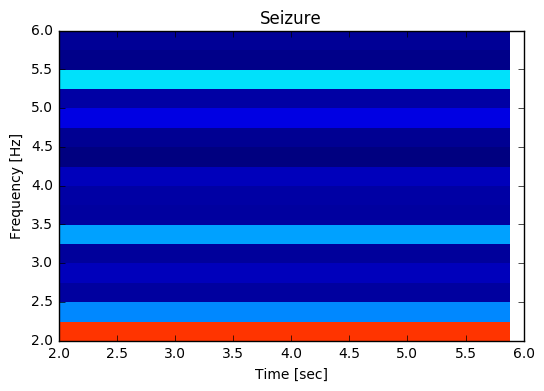

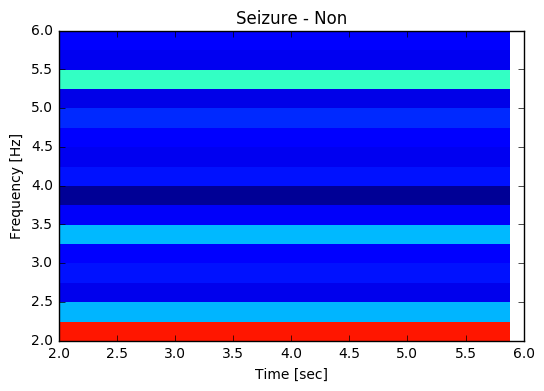

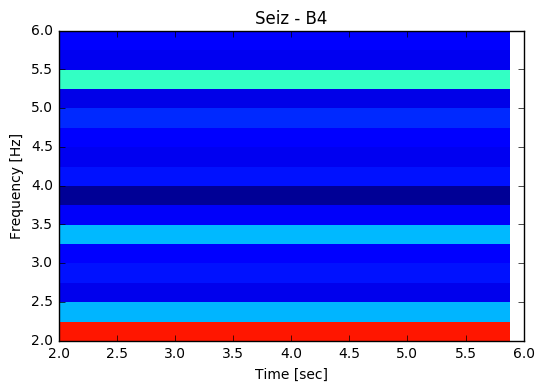

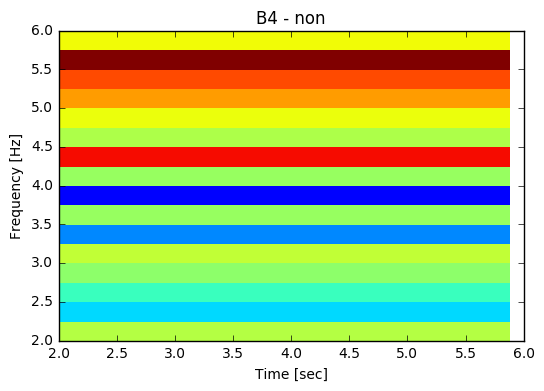

In [56]:
#There's less seiz data than b4 data
f,t, Sxx = signal.spectrogram(seizData[:640,2], fs=64, axis = 0, noverlap = 8)
plt.pcolormesh(t, f, Sxx)
plt.ylim([2,6])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Seizure')
plt.show()

f,t, Sxx2 = signal.spectrogram(nonData[:640,2], fs=64, axis = 0, noverlap = 8)
plt.pcolormesh(t, f, Sxx - Sxx2)
plt.ylim([2,6])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Seizure - Non')
plt.show()

f,t, Sxx3 = signal.spectrogram(b4Data[:640,2], fs=64, axis = 0, noverlap = 8)
plt.pcolormesh(t, f, Sxx - Sxx2)
plt.ylim([2,6])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Seiz - B4')
plt.show()

plt.pcolormesh(t, f, Sxx3 - Sxx2)
plt.ylim([2,6])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('B4 - non')
plt.show()